In [ ]:
#default_exp test

# Test

> test modules end to end

In [ ]:
#export
from torchtools.core import *
from torchtools.data import *
from torchtools.models import *
from torchtools.datasets import *
from torchtools.augmentations import *
from torchtools.datablock import *
from torchtools.dataloader import *

In [ ]:
#export
import numpy as np
import scipy as sp
#import torch
from fastai2.torch_basics import *
from fastai2.data.all import *
from fastai2.callback.all import *

from fastai2.data.all import *
from fastai2.basics import *

In [ ]:
#export
import psutil
import fastai2
import fastcore
import torch

### Workflow

- load data frame
- create a configuration: x_cols, y_cols [n_train optional]
- create X,y from df and configuration
- create splits and transforms
- create dsets
- define batch tranforms
- create dlets from datasets
- define loss and model
- create Learner -> learn

In [ ]:
nrows=200000
df_main = pd.read_csv('./data/custom/bi_sample_anon.csv', nrows=nrows)

In [ ]:
## simple config
x_cols = [[f'x{i}_{j}' for j in range(10)] for i in range(6)]
dep = 'y0'
n_train = 8000

In [ ]:
#export
def items_to_arrays(items):
    '''convert list of item tuples into X,y numpy arrays (for use with numpy dataloader)'''
#     return np.stack([x[0] for x in items]), np.stack([x[1] for x in items])
    return tuple(np.stack([x[i] for x in items]) for i in range(len(items[0])))

In [ ]:
items = df_to_items(df_main, x_cols, dep, n_train)[0]
X,y = items_to_arrays(items)

(200000, 6, 10)


In [ ]:
splits = FixedSplitter(n_train, n_train+5000)(df_main)
splits = FixedSplitter(120000, 160000)(df_main)

tfms = [None, None]

In [ ]:
L(splits).map(len)

(#2) [120000,40000]

In [ ]:
dsets = TSDatasets2(X=X, y=y, tfms=tfms, splits=splits, inplace=True)

[<class 'torchtools.data.TSTensor'>, None]


In [ ]:
aug_tfms = all_noise_augs(magnitude=0.4, verbose=True)+all_erasing_augs(
    magnitude=0.4, verbose=True)+all_zoom_augs(magnitude=0.4, verbose=True)

In [ ]:
# norm = TSNormalize(by_sample=False, by_var=True)
ss = TSStandardize(by_sample=False, by_var=True, verbose=True)
norm = TSNormalize(by_sample=False, by_var=True, verbose=True)


augs = TimestepZero(verbose=True)
augs = RandAugment(N=3, magnitude=0.4, tfms=aug_tfms)


tfms [YWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , YNormal: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , YScale: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , TimeWarp: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , TimeNormal: (TSTensor,object) -> encodes , Dimout: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , Cutout: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , TimestepZero: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , Crop: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , RandomCrop: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , Maskout: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , Zoomin: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , Zoomout: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , RandZoom: (TSIntTensor,object) -> encodes
(TSTensor,object) -> encodes , RandTimesteps:

In [ ]:
# %%time
# dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[256, 512], num_workers=0)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[256, 512], num_workers=0, 
#                                after_batch=[TSNormalize(by_var=False)
#                                after_batch=Pipeline(noop), ##??
                               batch_tfms=[ss, augs],
#                                batch_tfms=[norm, augs]
                               
#                                batch_tfms=[norm]
                              )

[<class 'torchtools.data.TSTensor'>, None]
[<class 'torchtools.data.TSTensor'>, None]
TSStandardize setup mean=None, std=None, by_sample=False, by_var=True
mean: tensor([[[-1.3464],
         [-1.4978],
         [ 0.0117],
         [-1.7581],
         [-1.9539],
         [-0.0117]]])  std: tensor([[[86.8401],
         [89.4383],
         [ 1.7140],
         [86.1442],
         [89.4364],
         [ 1.7140]]])



In [ ]:
xb, yb = dls.one_batch()

standardize encodes
yscale
ynormal
randomcrop


In [ ]:
xb.shape, type(xb)

(torch.Size([256, 6, 10]), torchtools.data.TSTensor)

In [ ]:
type(yb), type(xb)

(torch.Tensor, torchtools.data.TSTensor)

In [ ]:
set_seed(1234)
model = InceptionTimeSgm(6,1)
# model = InceptionTimeSgmOld(6,1)
# model = InceptionTime(6,1)

# loss_fn = F.cross_entropy
loss_fn = get_loss_fn('leaky_loss', alpha=0.5)
# loss_fn = F.mse_loss
# loss_fn = nll_leaky_loss

In [ ]:
learn = Learner(dls, model=model, loss_func=loss_fn, metrics=unweighted_profit)

In [ ]:
model(xb).shape

torch.Size([256, 1])

In [ ]:
unweighted_profit(model(xb), yb)

tensor(-0.6472, device='cuda:0')

In [ ]:
lr = 1e-5
wd = 0.03
epochs = 1
learn.fit_one_cycle(epochs, lr_max=lr, wd=wd)

epoch,train_loss,valid_loss,unweighted_profit,time
0,-0.063166,-0.112512,-0.027921,00:38


standardize encodes
randzoom
zoomin
ywarp
standardize encodes
ynormal
zoomout
maskout
standardize encodes
maskout
cutout
crop
standardize encodes
zoomin
zoomout
yscale
standardize encodes
timestepzero
randtimestep
timewarp
standardize encodes
crop
yscale
ywarp
standardize encodes
randzoom
crop
randomcrop
standardize encodes
ynormal
yscale
ywarp
standardize encodes
crop
timestepzero
timenormal torch.Size([256, 6, 10])
standardize encodes
timenormal torch.Size([256, 6, 10])
randomcrop
zoomout
standardize encodes
randomcrop
zoomout
yscale
standardize encodes
cutout
timenormal torch.Size([256, 6, 10])
randzoom
standardize encodes
randzoom
dimout
randtimestep
standardize encodes
randzoom
timestepzero
dimout
standardize encodes
ywarp
randzoom
ynormal
standardize encodes
timewarp
zoomin
randtimestep
standardize encodes
ynormal
randomcrop
timestepzero
standardize encodes
ynormal
randomcrop
randtimestep
standardize encodes
yscale
zoomout
ywarp
standardize encodes
randzoom
maskout
cutout
standar

standardize encodes
timewarp
ynormal
timestepzero
standardize encodes
ynormal
timestepzero
maskout
standardize encodes
timestepzero
cutout
randzoom
standardize encodes
timestepzero
timenormal torch.Size([256, 6, 10])
ywarp
standardize encodes
timewarp
timenormal torch.Size([256, 6, 10])
ynormal
standardize encodes
timewarp
zoomout
randomcrop
standardize encodes
randomcrop
dimout
timestepzero
standardize encodes
ynormal
randomcrop
zoomout
standardize encodes
ynormal
timenormal torch.Size([256, 6, 10])
zoomin
standardize encodes
timenormal torch.Size([256, 6, 10])
timewarp
randomcrop
standardize encodes
timenormal torch.Size([256, 6, 10])
randzoom
ynormal
standardize encodes
zoomout
crop
zoomin
standardize encodes
maskout
ywarp
dimout
standardize encodes
dimout
ywarp
randtimestep
standardize encodes
timestepzero
randzoom
ynormal
standardize encodes
zoomin
crop
cutout
standardize encodes
yscale
timenormal torch.Size([256, 6, 10])
zoomout
standardize encodes
timenormal torch.Size([256, 6, 

standardize encodes
zoomin
timewarp
timenormal torch.Size([256, 6, 10])
standardize encodes
randzoom
crop
maskout
standardize encodes
timestepzero
maskout
randomcrop
standardize encodes
timestepzero
zoomout
ynormal
standardize encodes
cutout
zoomout
randzoom
standardize encodes
ywarp
timewarp
zoomin
standardize encodes
ynormal
randzoom
zoomout
standardize encodes
maskout
randzoom
yscale
standardize encodes
crop
timenormal torch.Size([256, 6, 10])
ynormal
standardize encodes
cutout
timestepzero
timewarp
standardize encodes
maskout
randtimestep
randzoom
standardize encodes
zoomout
zoomin
randtimestep
standardize encodes
timenormal torch.Size([256, 6, 10])
zoomin
ynormal
standardize encodes
randomcrop
dimout
cutout
standardize encodes
ynormal
timestepzero
zoomin
standardize encodes
randtimestep
maskout
randomcrop
standardize encodes
dimout
randzoom
crop
standardize encodes
zoomin
yscale
ywarp
standardize encodes
timestepzero
timewarp
dimout
standardize encodes
randomcrop
randzoom
maskout


standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes


In [ ]:
unweighted_profit(model(xb), yb)

tensor(0.1725, device='cuda:0')

In [ ]:
preds, y_true = learn.get_preds()

standardize encodes


standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes
standardize encodes


In [ ]:
unweighted_profit(preds, y_true)

tensor(-0.0279)

In [ ]:
preds.max()

tensor(0.1916)

In [ ]:
preds.shape

torch.Size([40000, 1])

(array([2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 4.000e+00, 6.000e+00, 6.000e+00, 1.000e+01, 1.200e+01,
        1.100e+01, 1.500e+01, 2.500e+01, 1.500e+01, 1.800e+01, 2.200e+01,
        2.900e+01, 4.300e+01, 4.200e+01, 5.200e+01, 4.900e+01, 6.600e+01,
        7.100e+01, 8.500e+01, 1.130e+02, 1.060e+02, 1.500e+02, 1.410e+02,
        1.760e+02, 2.290e+02, 2.390e+02, 2.670e+02, 3.170e+02, 3.720e+02,
        3.970e+02, 4.430e+02, 4.760e+02, 5.040e+02, 6.250e+02, 6.970e+02,
        6.960e+02, 8.260e+02, 8.620e+02, 9.280e+02, 1.034e+03, 1.058e+03,
        1.140e+03, 1.177e+03, 1.202e+03, 1.203e+03, 1.257e+03, 1.286e+03,
        1.413e+03, 1.394e+03, 1.273e+03, 1.333e+03, 1.245e+03, 1.292e+03,
        1.185e+03, 1.176e+03, 1.152e+03, 1.055e+03, 9.580e+02, 9.420e+02,
        9.020e+02, 7.350e+02, 6.810e+02, 6.670e+02, 5.770e+02, 5.410e+02,
        4.610e+02, 3.840e+02, 3.510e+02, 2.820e+02, 2.530e+02, 2.130e+02,
        2.020e+02, 1.470e+02, 1.300e+0

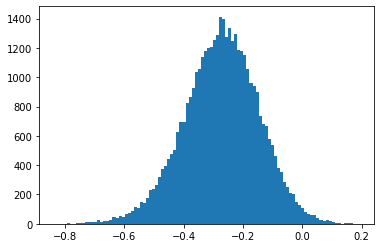

In [ ]:
plt.hist(preds.squeeze().cpu().numpy(), bins=100)